# <h1><center>Heart Attack Dataset -- Modeling</center></h1>

### <center>By: Hio Wa Mak</center>

# Import packages

In [23]:
#Import packages
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import uniform 
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn import linear_model, preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_predict
import statsmodels.api as sm 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Read in the data

In [2]:
# Read CSV files into DataFrames
X_train_scaled_df = pd.read_csv('../data/X_train_scaled.csv')
X_test_scaled_df = pd.read_csv('../data/X_test_scaled.csv')
y_train_df = pd.read_csv('../data/y_train.csv')
y_test_df = pd.read_csv('../data/y_test.csv')
X = pd.read_csv('../data/X.csv')

# Convert DataFrames to Numpy arrays
X_train= X_train_scaled_df.values
X_test = X_test_scaled_df.values
y_train = y_train_df.values.ravel()
y_test = y_test_df.values.ravel()

# Dealing with Imbalanced data

In the Heart Attack dataset, the target variable 'HadHeartAttack' is imbalanced (94% of the participants had not had an heart attack). I will explore a few different methods in dealing with imbalanced data so that the classification results, especially those target imbalanced data, are improved and generalizable to the testing data.

Here are a few strategies:
1. Select evaluation metrics that are better for imbalanced data, including precision, recall, and f1-score
2. Add class_weights in the models so that it adjusts for imbalanced data

# Modeling

## Logistic Regression

Let's fit a regular logistic regression model using randomized search cross-validation, and accuracy as scoring criterion

In [24]:
#Fit a logistic regression model

#Define parameters for randomized search
param_distributions = {
    'C': uniform(0.001, 100),  # Uniform distribution for C, ranges from 0.001 to 100
    'penalty': ['l1', 'l2'],   # Regularization type (L1 = Lasso, L2 = Ridge)
    'solver': ['liblinear', 'saga']  # Solvers that support L1 and L2
}

#Set up the logistic regression model
logreg = LogisticRegression()

# Perform randomized search with 10 iterations and 5-fold cross-validation
logreg_random = RandomizedSearchCV(estimator = logreg, 
                                   param_distributions = param_distributions, 
                                   n_iter=20, 
                                   cv=5, 
                                   scoring='accuracy', 
                                   random_state=42, 
                                   verbose=1,
                                   n_jobs=-1)

# Time the fitting process
start_time = time.time()
logreg_random.fit(X_train, y_train)
end_time = time.time()
est_time = (end_time - start_time)

# Print estimation time
print(f"Estimation time: {est_time/60:.2f} minutes")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Estimation time: 20.61 minutes


In [25]:
# Obtain evaluation metrics for training data:
# Step 1: Use cross_val_predict to get cross-validated predictions for training data
y_train_pred = cross_val_predict(logreg_random.best_estimator_, X_train, y_train, cv=5)

# Step 2: Calculate the confusion matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)

# Step 3: Generate the classification report
class_report = classification_report(y_train, y_train_pred)

# Print results
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[322946   3582]
 [ 15045   4674]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97    326528
           1       0.57      0.24      0.33     19719

    accuracy                           0.95    346247
   macro avg       0.76      0.61      0.65    346247
weighted avg       0.93      0.95      0.94    346247



Although accuracy score is very high (0.95), the recall score is very low (0.24) for the positive class. For imbalanced data, recall is a more important metric than accuracy, especially the goal is to minimize false negative.

## Logistic regression

### 'class_weight' as hyperparameter and 'recall' as evaluation metric for cross validation

In [26]:
#Since we have unbalanced design, let's do this again using class_weight as a hyperparameter for tuning 
#And using "recall" as the main evaluation metric

#Fit a logistic regression model
#Define parameters for randomized search
param_distributions = {
    'C': uniform(0.001, 100),  # Uniform distribution for C, ranges from 0.001 to 100
    'penalty': ['l1', 'l2'],   # Regularization type (L1 = Lasso, L2 = Ridge)
    'solver': ['liblinear', 'saga'],  # Solvers that support L1 and L2
    'class_weight': [None, 'balanced']
}

#Set up the logistic regression model
logreg = LogisticRegression()

# Perform randomized search with 10 iterations and 5-fold cross-validation
logreg_random = RandomizedSearchCV(estimator = logreg, 
                                   param_distributions = param_distributions, 
                                   n_iter=20, # Number of different combinations to try
                                   cv=5, 
                                   scoring='recall', 
                                   random_state=42, 
                                   verbose=1,
                                   n_jobs=-1) # Use all available cores (8)

# Time the fitting process
start_time = time.time()
logreg_random.fit(X_train, y_train)
end_time = time.time()
est_time = (end_time - start_time)

# Print estimation time
print(f"Estimation time: {est_time/60:.2f} minutes")

# Print the best parameters
print("Best hyperparameters found:", logreg_random.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Estimation time: 12.01 minutes
Best hyperparameters found: {'C': 33.371861113902185, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}


In [27]:
# Obtain evaluation metrics for training data:
# Step 1: Use cross_val_predict to get cross-validated predictions for training data
y_train_pred = cross_val_predict(logreg_random.best_estimator_, X_train, y_train, cv=5)

# Step 2: Calculate the confusion matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)

# Step 3: Generate the classification report
logreg_class_report = classification_report(y_train, y_train_pred)

# Print results
print("Confusion Matrix:")
print(conf_matrix)

print("\nLogistic Regression Classification Report:")
print(logreg_class_report)

Confusion Matrix:
[[272373  54155]
 [  4638  15081]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.83      0.90    326528
           1       0.22      0.76      0.34     19719

    accuracy                           0.83    346247
   macro avg       0.60      0.80      0.62    346247
weighted avg       0.94      0.83      0.87    346247



In [28]:
#Examine feature coefficient from the best model
coefficients = logreg_random.best_estimator_.coef_[0]

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
})

# Sort by absolute value of coefficients
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

#The top 20 features
print(feature_importance[0:20])

                    Feature  Coefficient  Abs_Coefficient
25              AgeCategory     0.707942         0.707942
7                 HadAngina     0.591795         0.591795
27                   Female    -0.334749         0.334749
3           LastCheckupTime    -0.292839         0.292839
24                ChestScan     0.234134         0.234134
8                 HadStroke     0.231545         0.231545
6              RemovedTeeth     0.167005         0.167005
22             SmokerStatus     0.131649         0.131649
15              HadDiabetes     0.131207         0.131207
4        PhysicalActivities    -0.076401         0.076401
11                  HadCOPD     0.060892         0.060892
26          AlcoholDrinkers    -0.053241         0.053241
13         HadKidneyDisease     0.051079         0.051079
28              BMICategory     0.049138         0.049138
0             GeneralHealth    -0.045225         0.045225
34                 Colorado     0.041456         0.041456
17  BlindOrVis

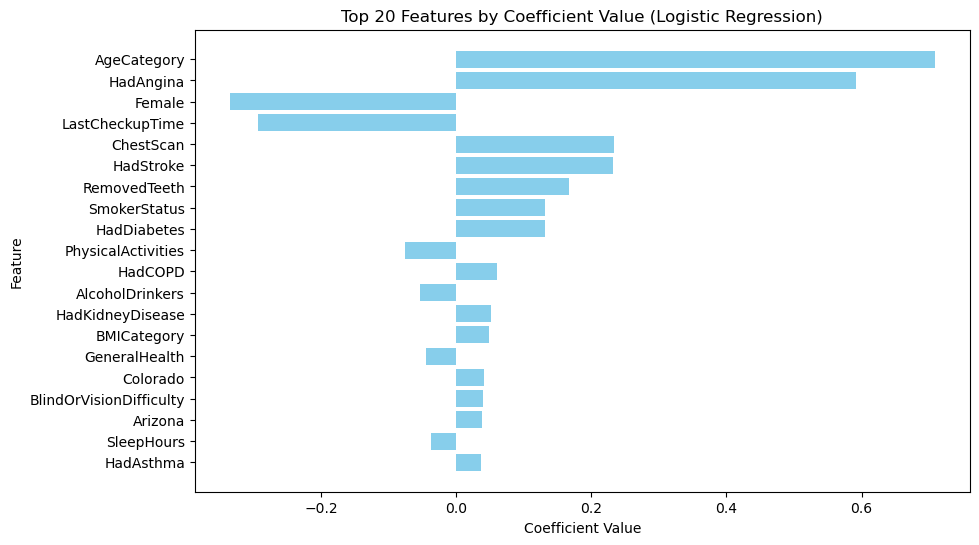

In [29]:
# Plot the top 20 features based on absolute coefficient values
top_20_features = feature_importance.head(20)  # Select the top 20 features

plt.figure(figsize=(10, 6))
plt.barh(top_20_features['Feature'], top_20_features['Coefficient'], color='skyblue')  # Horizontal bar plot
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 20 Features by Coefficient Value (Logistic Regression)')
plt.gca().invert_yaxis()  # Invert y-axis to have the largest feature at the top
plt.show()

## Random Forest

Tree-based model can be a good choice for imbalanced data. Let's fit a random forest model

In [30]:
#Fit a random forest model

#Define parameters for randomized search

param_dist = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'class_weight': [None, 'balanced']
    #'min_samples_split': [2, 5, 10],
    #'min_samples_leaf': [1, 2, 4],
}

#Set up the random forest model
rf = RandomForestClassifier(random_state=42)

# Setup the RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator=rf,
                               param_distributions=param_dist,
                               n_iter=20,  
                               cv=5, 
                               scoring="recall",
                               verbose=2,
                               random_state=42,
                               n_jobs=-1)  

# Time the fitting process
start_time = time.time()
rf_random.fit(X_train, y_train)
end_time = time.time()
est_time = (end_time - start_time)

# Print estimation time
print(f"Estimation time: {est_time/60:.2f} minutes")

# Print the best parameters
print("Best hyperparameters found:", rf_random.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Estimation time: 78.78 minutes
Best hyperparameters found: {'n_estimators': 200, 'max_features': 'log2', 'max_depth': 10, 'criterion': 'entropy', 'class_weight': 'balanced'}


In [31]:
# Obtain evaluation metrics for training data:
# Step 1: Use cross_val_predict to get cross-validated predictions for training data
y_train_pred = cross_val_predict(rf_random.best_estimator_, X_train, y_train, cv=5)

# Step 2: Calculate the confusion matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)

# Step 3: Generate the classification report
rf_class_report = classification_report(y_train, y_train_pred)

# Print results
print("Confusion Matrix:")
print(conf_matrix)

print("\nRandom Forest Classification Report:")
print(rf_class_report)

Confusion Matrix:
[[265230  61298]
 [  4321  15398]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.81      0.89    326528
           1       0.20      0.78      0.32     19719

    accuracy                           0.81    346247
   macro avg       0.59      0.80      0.60    346247
weighted avg       0.94      0.81      0.86    346247



In [38]:
#TN, FP, FN, TP = conf_matrix.ravel()
#print(f'accuracy: {(TP + TN)/(TP + TN + FP + FN):.4f}')
#print(f'precision: {TP/(TP+ FP):.4f}')
#print(f'recall: {TP/(TP+ FN):.4f}')
#print(f'f1-score: {2*TP/(2*TP+ FP+ FN):.4f}')

In [32]:
#Examine feature coefficient from the best model
importances = rf_random.best_estimator_.feature_importances_  # Get feature importances

# Create a DataFrame to display the feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the top 20 most important features
print(feature_importance_df.head(20))

                Feature  Importance
7             HadAngina    0.291904
25          AgeCategory    0.140246
24            ChestScan    0.079703
3       LastCheckupTime    0.066297
6          RemovedTeeth    0.055570
19    DifficultyWalking    0.044730
8             HadStroke    0.043432
15          HadDiabetes    0.037931
14         HadArthritis    0.030979
1    PhysicalHealthDays    0.023853
11              HadCOPD    0.023411
27               Female    0.021477
22         SmokerStatus    0.020051
16  DeafOrHardOfHearing    0.014595
5            SleepHours    0.012178
4    PhysicalActivities    0.011619
13     HadKidneyDisease    0.011372
26      AlcoholDrinkers    0.007027
0         GeneralHealth    0.006519
21    DifficultyErrands    0.005905


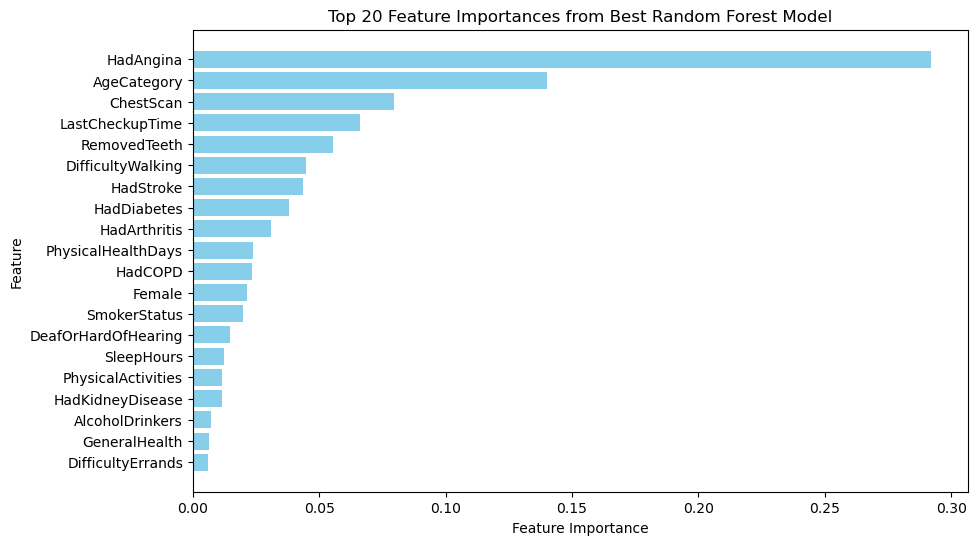

In [33]:
# Select the top 20 most important features
top_20_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)

# Plot the top 20 feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_20_features['Feature'], top_20_features['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances from Best Random Forest Model')
plt.gca().invert_yaxis()  # Invert y-axis to show most important at the top
plt.show()

## Support Vector Machine (SVMs)

Support vector machine are computationally expensive, especially for large datasets, which is the case here (~400000 participants). I will need to undersample the majority class to help with class-imbalanced problem and to reduce computational time.

In [3]:
# Initialize the undersampler
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
#undersample the majority class to 50% of the minority class

# Apply undersampling on the training data
X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train, y_train)

print(f"Original dataset shape: {X_train.shape}")
print(f"Undersampling dataset shape: {X_train_undersampled.shape}")

Original dataset shape: (346247, 83)
Undersampling dataset shape: (39438, 83)


In [6]:
# Initialize the SVM model with default hyperparameters
svm_model = SVC(kernel='linear', C=1.0, random_state=42)

# Fit the SVM model on the training data
# Time the fitting process
start_time = time.time()
svm_model.fit(X_resampled, y_resampled)
end_time = time.time()
est_time = (end_time - start_time)

# Print estimation time
print(f"Estimation time: {est_time/60:.2f} minutes")

In [8]:
# Print estimation time
print(f"Estimation time: {est_time/60:.2f} minutes")

# Make predictions
y_resampled_pred = svm_model.predict(X_resampled)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_resampled, y_resampled_pred)

# Generate the classification report
svm_class_report = classification_report(y_resampled, y_resampled_pred)

# Print results
print("Confusion Matrix:")
print(conf_matrix)

print("\nSVM Classification Report:")
print(svm_class_report)

Estimation time: 21.56 minutes
Confusion Matrix:
[[36951  2487]
 [ 8468 11251]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.94      0.87     39438
           1       0.82      0.57      0.67     19719

    accuracy                           0.81     59157
   macro avg       0.82      0.75      0.77     59157
weighted avg       0.82      0.81      0.80     59157



In [ ]:
# Define parameters for randomized search for SVM
param_dist = {
    'C': [0.1, 1, 10, 100],   # Regularization parameter
    'kernel': ['linear', 'poly'],  # Kernel types
    'gamma': ['scale', 'auto'],  # Kernel coefficient
    'class_weight': [None, 'balanced']  # Handling imbalanced data
}

# Set up the SVM model
svm = SVC(random_state=42)

# Setup the RandomizedSearchCV
svm_random = RandomizedSearchCV(estimator=svm,
                                param_distributions=param_dist,
                                n_iter=1,
                                cv=5,
                                scoring="recall",
                                verbose=2,
                                random_state=42,
                                n_jobs=-1)

# Time the fitting process
start_time = time.time()
svm_random.fit(X_train_undersampled, y_train_undersampled)
end_time = time.time()
est_time = (end_time - start_time)

# Print estimation time
print(f"Estimation time: {est_time/60:.2f} minutes")

# Print the best parameters
print("Best hyperparameters found:", svm_random.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [ ]:
# Obtain evaluation metrics for training data:
# Step 1: Use cross_val_predict to get cross-validated predictions for training data
y_train_pred = cross_val_predict(svm_random.best_estimator_, X_train, y_train, cv=5)

# Step 2: Calculate the confusion matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)

# Step 3: Generate the classification report
class_report = classification_report(y_train, y_train_pred)

# Print results
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)

In [ ]:
#Examine feature coefficient from the best model
coefficients = svm_random.best_params_.coef_[0]

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
})

print(feature_importance)

# Sort by absolute value of coefficients
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

#The top 20 features
print(feature_importance[0:20])

In [ ]:
# Plot the top 20 features based on absolute coefficient values
top_20_features = feature_importance.head(20)  # Select the top 20 features

plt.figure(figsize=(10, 6))
plt.barh(top_20_features['Feature'], top_20_features['Coefficient'], color='skyblue')  # Horizontal bar plot
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 20 Features by Coefficient Value (Logistic Regression)')
plt.gca().invert_yaxis()  # Invert y-axis to have the largest feature at the top
plt.show()

## Extreme Gradient Boosting (XGBoost)

XGBoost is a boosting ensemble method, with sequential training of individual models. This method can handle imbalanced data well.

In [34]:
# Define the parameter grid for XGBoost
param_distributions = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [3, 5, 7, 10],      # Maximum depth of trees
    'min_child_weight': [1, 3, 5, 7],  # Minimum sum of weights in a child node
    'subsample': [0.7, 0.8, 1.0],    # Subsample ratio
    'colsample_bytree': [0.7, 0.8, 1.0], # Fraction of features to be used for each tree
    'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage
    'gamma': [0, 0.1, 0.2],           # Minimum loss reduction
    'reg_alpha': [0, 0.1, 1],         # L1 regularization term
    'reg_lambda': [1, 1.5, 2],         # L2 regularization term
    'scale_pos_weight': [10, 15.7, 20]  # Handling imbalanced data
}

# Set up the XGBoost classifier
xgb = XGBClassifier(random_state=42)

# Perform randomized search with 10 iterations and 5-fold cross-validation
xgb_random = RandomizedSearchCV(estimator=xgb, 
                                param_distributions=param_distributions, 
                                n_iter=20,  
                                cv=5,       
                                scoring='recall', 
                                random_state=42, 
                                verbose=1, 
                                n_jobs=-1)

# Time the fitting process
start_time = time.time()
xgb_random.fit(X_train, y_train)
end_time = time.time()
est_time = (end_time - start_time)

# Print estimation time
print(f"Estimation time: {est_time/60:.2f} minutes")

# Print the best parameters found by RandomizedSearchCV
print("Best hyperparameters found:", xgb_random.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Estimation time: 6.54 minutes
Best hyperparameters found: {'subsample': 0.7, 'scale_pos_weight': 20, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.8}


In [35]:
# Obtain evaluation metrics for training data:
# Step 1: Use cross_val_predict to get cross-validated predictions for training data
y_train_pred = cross_val_predict(xgb_random.best_estimator_, X_train, y_train, cv=5)

# Step 2: Calculate the confusion matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)

# Step 3: Generate the classification report
xgb_class_report = classification_report(y_train, y_train_pred)

# Print results
print("Confusion Matrix:")
print(conf_matrix)

print("\nXGBoost Classification Report:")
print(xgb_class_report)

Confusion Matrix:
[[244586  81942]
 [  3128  16591]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.75      0.85    326528
           1       0.17      0.84      0.28     19719

    accuracy                           0.75    346247
   macro avg       0.58      0.80      0.57    346247
weighted avg       0.94      0.75      0.82    346247



## Naïve Bayes

### Gaussian Naïve Bayes

In [36]:
#Treating features as continuous, use GaussianNB
# Define parameters for randomized search for Naive Bayes (GaussianNB)
param_dist = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]  # Variance smoothing parameter for GaussianNB
}

# Set up the Gaussian Naive Bayes model
gnb = GaussianNB()

# Setup the RandomizedSearchCV
nb_random = RandomizedSearchCV(estimator=gnb,
                               param_distributions=param_dist,
                               n_iter=4,  # Number of different combinations to try
                               cv=5,  # Number of cross-validation folds
                               scoring="recall",
                               verbose=2,
                               random_state=42,
                               n_jobs=-1)  # Use all available cores

# Time the fitting process
start_time = time.time()
nb_random.fit(X_train, y_train)
end_time = time.time()
est_time = (end_time - start_time)

# Print estimation time
print(f"Estimation time: {est_time/60:.2f} minutes")

# Print the best parameters
print("Best hyperparameters found:", nb_random.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Estimation time: 0.10 minutes
Best hyperparameters found: {'var_smoothing': 1e-09}


In [37]:
# Obtain evaluation metrics for training data:
# Step 1: Use cross_val_predict to get cross-validated predictions for training data
y_train_pred = cross_val_predict(nb_random.best_estimator_, X_train, y_train, cv=5)

# Step 2: Calculate the confusion matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)

# Step 3: Generate the classification report
nb_class_report = classification_report(y_train, y_train_pred)

# Print results
print("Confusion Matrix:")
print(conf_matrix)

print("\nNaïve Bayes Classification Report:")
print(nb_class_report)

Confusion Matrix:
[[266989  59539]
 [  5780  13939]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.82      0.89    326528
           1       0.19      0.71      0.30     19719

    accuracy                           0.81    346247
   macro avg       0.58      0.76      0.60    346247
weighted avg       0.93      0.81      0.86    346247



## Model Selection

Given the imbalanced data, I use the recall score for the positive calss and macro average of the recall scores across classes for selecting the best model. Here is the comparison for the four models:
1. Logistic regression: recall(1) = 0.76; recall(avg) = 0.80; precision = , f1-score = 
2. Random forest: recall(1) = 0.78; recall(avg) = 0.80; precision = , f1-score =  
3. XGBoost: recall(1) = 0.84; recall(avg) = 0.80; precision = , f1-score = 
4. Naive Bayes: recall(1) = 0.71; recall(avg) = 0.76; precision = , f1-score = 

In [ ]:
print("\nLogistic Regression Classification Report:")
print(logreg_class_report)

print("\nRandom Forest Classification Report:")
print(rf_class_report)

print("\nXGBoost Classification Report:")
print(xgb_class_report)

print("\nNaïve Bayes Classification Report:")
print(nb_class_report)

Therefore, XGBoost is our best model.

## Final Model and Pipeline

## Final Model Evaluation

In [ ]:
# Evaluate on the test set
y_pred = xxx.predict(X_test)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Generate the classification report
class_report = classification_report(y_test, y_pred)

# Print results
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)

### Save the Final Model

In [19]:
#Dummy encoding (state + race)
path = 'D:\\Springboard\\Projects\\capstone2\\Heart-Attack\\data\\'



## Summary

In this modeling stage, the primary objective is to choose the best classifier and best model parameters for predicting Heart Attack in the dataset. This involves a series of steps: 1) run a few different models (logistic regression, random forest, XGBoost, and Naive Bayes Classifier), 2) examine a evaluation metrics, including accuracy, precision, recall, and f-1 score, 3) Choose the best model based on a specific evaluation metric (i.e., recall here because we want to minimize the risk false negatives -- the risk saying that a person does not have heart attack when in fact the person has) and identify be best parameters, 4) examine performace or evaluation metrics on the test set, 5) examine feature importance, and 6) create pipeline for the final model.
